## 0. Loading the data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

data = tf.keras.datasets.cifar10.load_data()
(X_train, y_train), (X_test, y_test) = data

## 1. CIFAR-10 Dataset

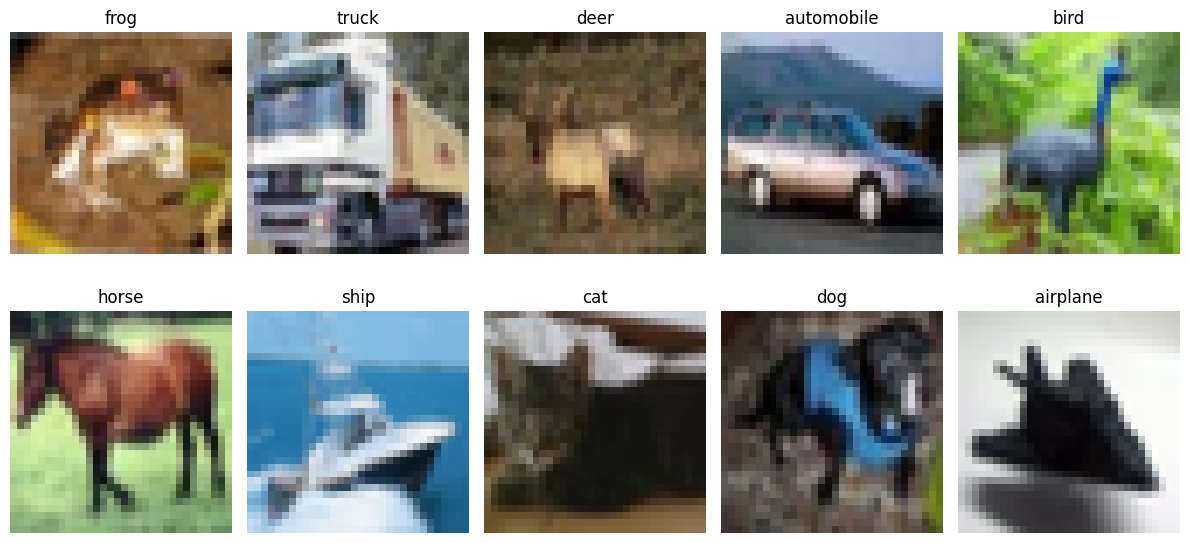

In [2]:
# Class labels for CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a figure with subplots
plt.figure(figsize=(12, 6))

# To store one image per class
samples_per_class = {}

# Iterate over the dataset to find one sample per class
for i, (image, label) in enumerate(zip(X_train, y_train)):
    class_idx = label[0]  # Extract class index from label
    if class_idx not in samples_per_class:
        samples_per_class[class_idx] = image  # Store the first occurrence of each class
    if len(samples_per_class) == len(class_names):  # Break if all classes have been found
        break

# Plot each class with its corresponding image
for idx, (class_idx, image) in enumerate(samples_per_class.items()):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image)
    plt.title(f'{class_names[class_idx]}')
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


## 2. Data Preparation

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import os
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split


# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify= y_train)

# Normalize pixel values
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

# CIFAR-10 has 10 classes
num_classes = 10

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

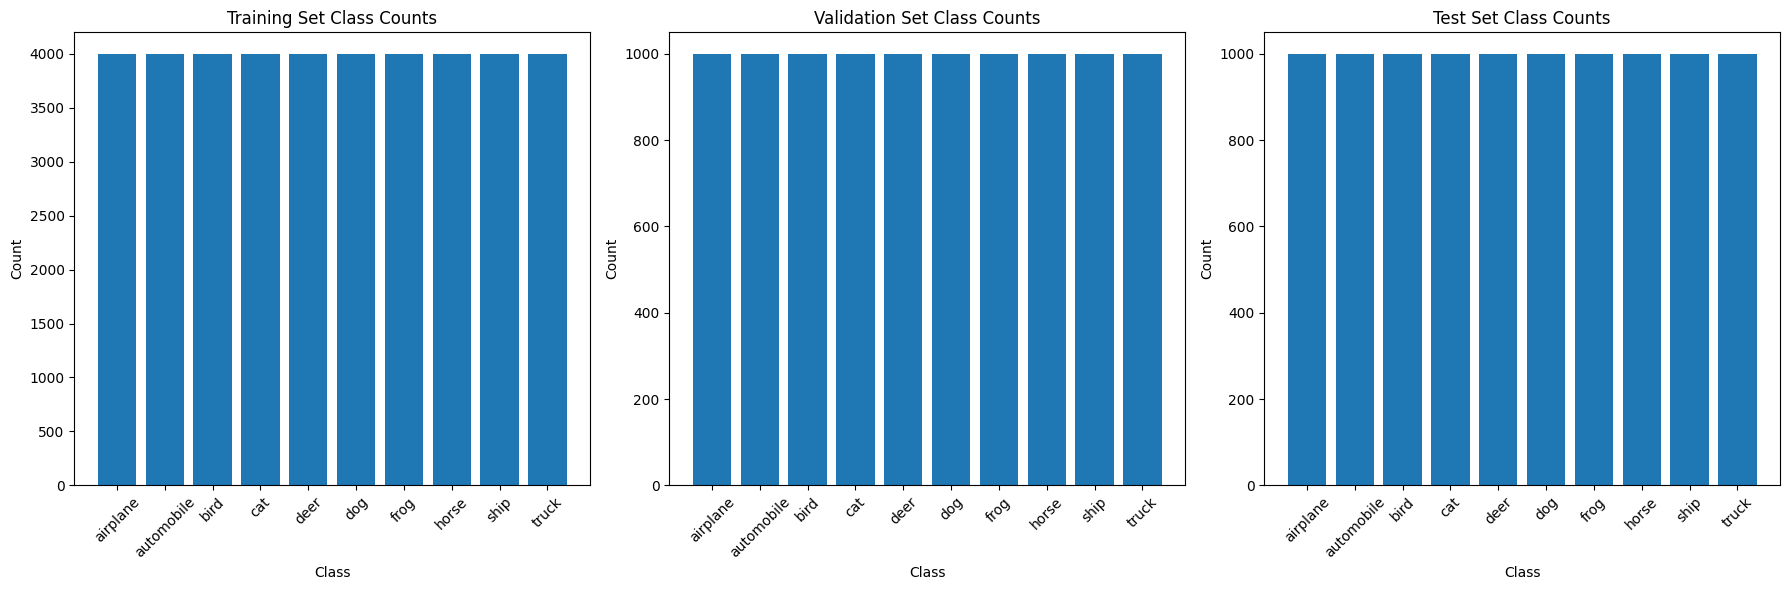

In [4]:
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Count occurrences of each class in training, validation, and test sets
unique_train, counts_train = np.unique(y_train_labels, return_counts=True)
unique_val, counts_val = np.unique(y_val_labels, return_counts=True)
unique_test, counts_test = np.unique(y_test_labels, return_counts=True)

# Plot bar charts for training, validation, and test set class counts with class names
plt.figure(figsize=(18, 6))

# Training set
plt.subplot(1, 3, 1)
plt.bar(class_names, counts_train)
plt.title("Training Set Class Counts")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Validation set
plt.subplot(1, 3, 2)
plt.bar(class_names, counts_val)
plt.title("Validation Set Class Counts")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Test set
plt.subplot(1, 3, 3)
plt.bar(class_names, counts_test)
plt.title("Test Set Class Counts")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 3. Model Training

In [5]:
batch_size = 32

def residual_block(x, filters, kernel_size=3, stride=1, downsample=False):
    identity = x

    if downsample:
        # Downsample the input with convolution if needed
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(identity)
        identity = layers.BatchNormalization()(identity)

    # First convolutional layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add the identity (skip connection)
    x = layers.add([x, identity])
    x = layers.ReLU()(x)

    return x

def plain_block(x, filters, kernel_size=3, stride=1):
    # Without residual link
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


def build_resnet18(input_shape=(32, 32, 3), num_classes=10, use_residual=True):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Select the type of block based on the `use_residual` flag
    block_fn = residual_block if use_residual else plain_block

    # First block (64 filters)
    x = block_fn(x, 64)
    x = block_fn(x, 64)

    # Second block (128 filters)
    if use_residual:
        x = block_fn(x, 128, downsample=True)
    else:
        x = block_fn(x, 128)
    x = block_fn(x, 128)

    # Third block (256 filters)
    if use_residual:
        x = block_fn(x, 256, downsample=True)
    else:
        x = block_fn(x, 256)
    x = block_fn(x, 256)

    # Fourth block (512 filters)
    if use_residual:
        x = block_fn(x, 512, downsample=True)
    else:
        x = block_fn(x, 512)
    x = block_fn(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model



def build_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()

    # 1st Convolutional Layer
    model.add(layers.Conv2D(filters=96, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 2nd Convolutional Layer
    model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 3rd Convolutional Layer
    model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())

    # 4th Convolutional Layer
    model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())

    # 5th Convolutional Layer
    model.add(layers.Conv2D(filters=256, kernel_size=(1, 1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the layers and pass them through fully connected layers
    model.add(layers.Flatten())

    # 1st Fully Connected Layer
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # 2nd Fully Connected Layer
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

def build_vgg16(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()

    # 1st Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 2nd Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 3rd Convolutional Block
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 4th Convolutional Block
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 5th Convolutional Block
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the layers
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


def train_model(build_model, model_name, parameters, epoch, model_dir='saved_models', verbose=1):
    # Check if model already exists in the directory
    model_path = os.path.join(model_dir, f'{model_name}.h5')
    history_path = os.path.join(model_dir, f'{model_name}_history.pkl')
    
    if os.path.exists(model_path):
        model = load_model(model_path)
        if os.path.exists(history_path):
            with open(history_path, 'rb') as f:
                history = pickle.load(f)
        else:
            history = None
        return history, model  # Return history and model
    
    # If not found, train a new model
    model = build_model()
    model.compile(optimizer=parameters["optimizer"],
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epoch, 
                        validation_data=(X_val, y_val), 
                        batch_size=batch_size,
                        callbacks=[early_stopping],
                        verbose=verbose)
    
    # Save the model and history
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model.save(model_path)
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    
    return history, model

def train_all(models_dict, parameters, status, epochs, train_function):
    model_histories = {}

    # Train or load each model in a loop
    for name, build_model in models_dict.items():
        model_name = f"{status}{name}"
        training_history, training_model = train_function(build_model, model_name, parameters[name], epochs)
        
        # Store the history and model
        model_histories[model_name] = (training_history, training_model)

    return model_histories

def compare_training_metrics(histories, title):
    # Define metrics and titles for training metrics
    train_metrics = ['accuracy', 'loss']
    train_titles = ['Training Accuracy', 'Training Loss']
    
    # Define metrics and titles for validation metrics
    val_metrics = ['val_accuracy', 'val_loss']
    val_titles = ['Validation Accuracy', 'Validation Loss']
    
    # Plot training metrics
    plt.figure(figsize=(14, 7))
    for i, metric in enumerate(train_metrics):
        plt.subplot(1, 2, i + 1)
        for model_name, (history, _) in histories.items():
            try:
                data = history.history[metric]
            except:
                data = history[metric]
            plt.plot(data, label=f'{model_name} {metric.replace("_", " ").capitalize()}')
        plt.title(f"{title} {train_titles[i]}")
        plt.xlabel('Epochs')
        plt.ylabel(metric.replace('_', ' ').capitalize())
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot validation metrics
    plt.figure(figsize=(14, 7))
    for i, metric in enumerate(val_metrics):
        plt.subplot(1, 2, i + 1)
        for model_name, (history, _) in histories.items():
            try:
                data = history.history[metric]
            except:
                data = history[metric]
            plt.plot(data, label=f'{model_name} {metric.replace("_", " ").capitalize()}')
        plt.title(f"{title} {val_titles[i]}")
        plt.xlabel('Epochs')
        plt.ylabel(metric.replace('_', ' ').capitalize())
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()



## 4. Baseline Parameters

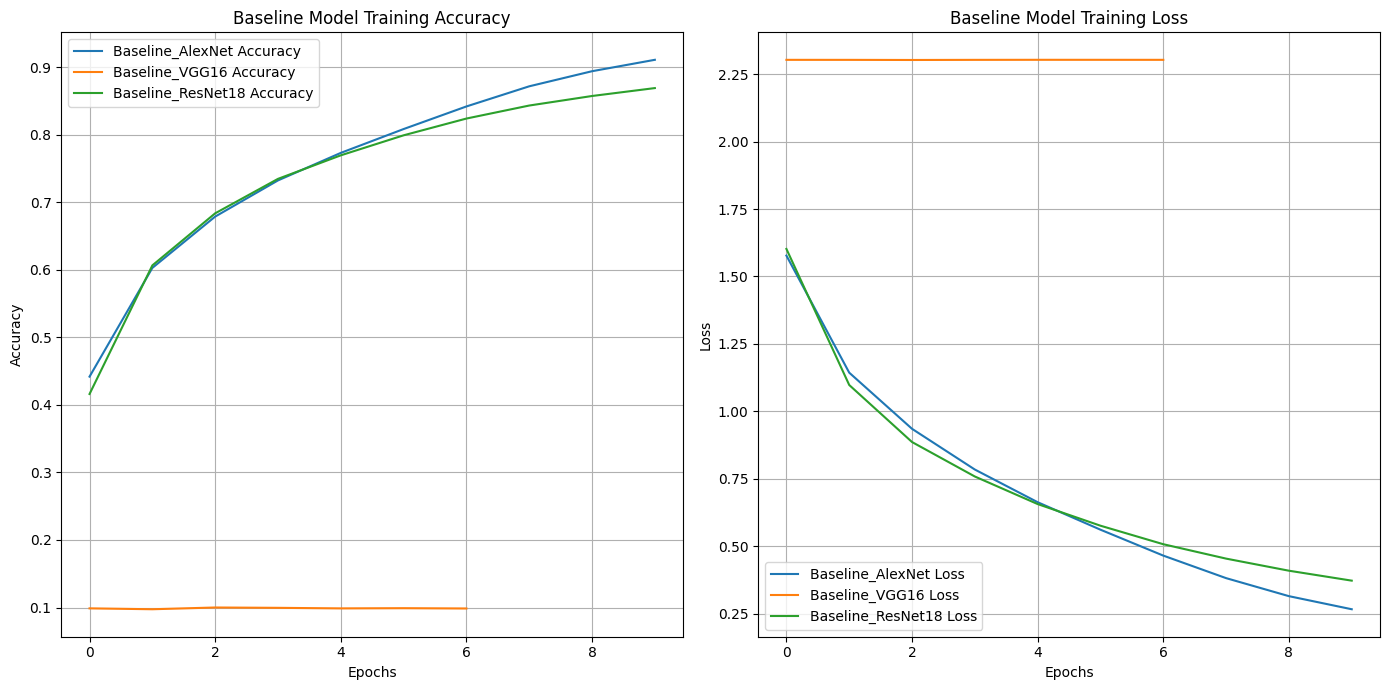

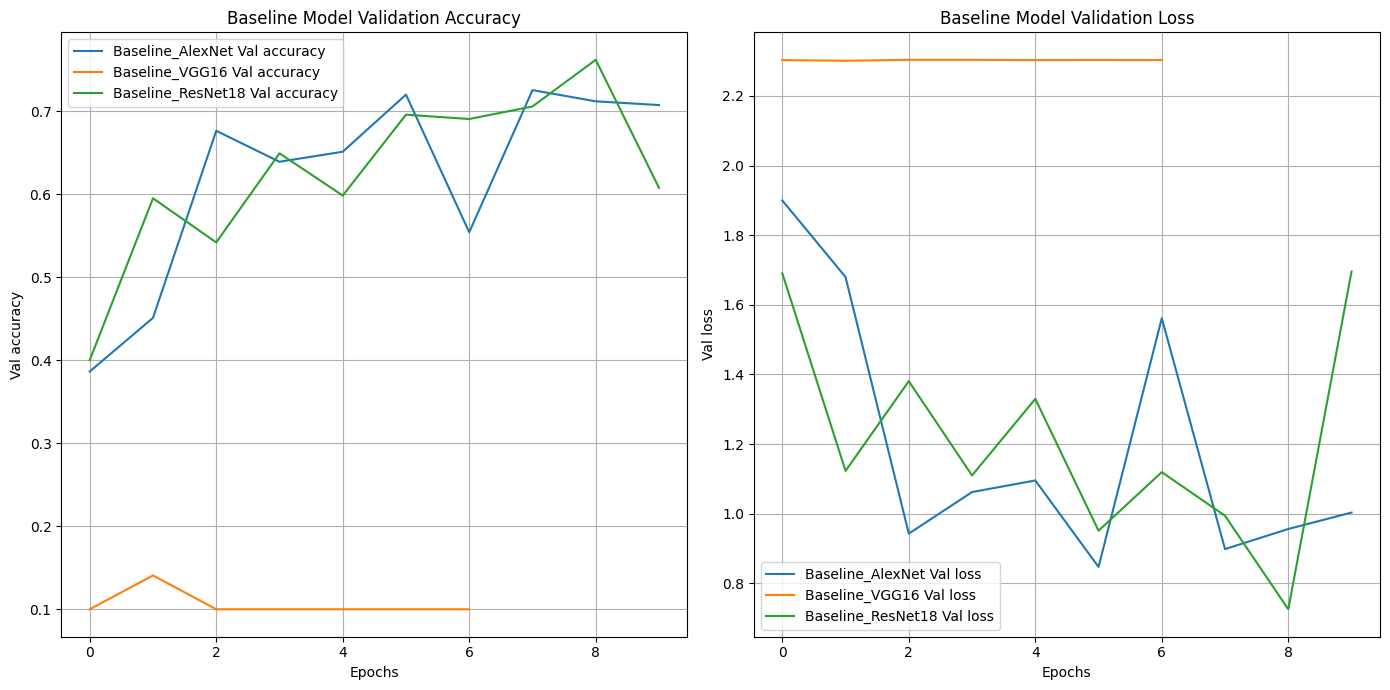

In [ ]:
model_dict = {'AlexNet':build_alexnet,  'VGG16':build_vgg16, 'ResNet18':build_resnet18}

parameters = {"AlexNet" : {'optimizer': tf.keras.optimizers.SGD(learning_rate=0.1)},
              "VGG16" : {'optimizer': tf.keras.optimizers.SGD(learning_rate=0.1)},
              "ResNet18" : {'optimizer':tf.keras.optimizers.SGD(learning_rate=0.1)}}

baseline_histories = train_all(model_dict, parameters, 'Baseline_', 10, train_model)

compare_training_metrics(baseline_histories, "Baseline Model")

## 5. Hyperparameter Optimization

### 5.1 Optimizer and Learning Rate

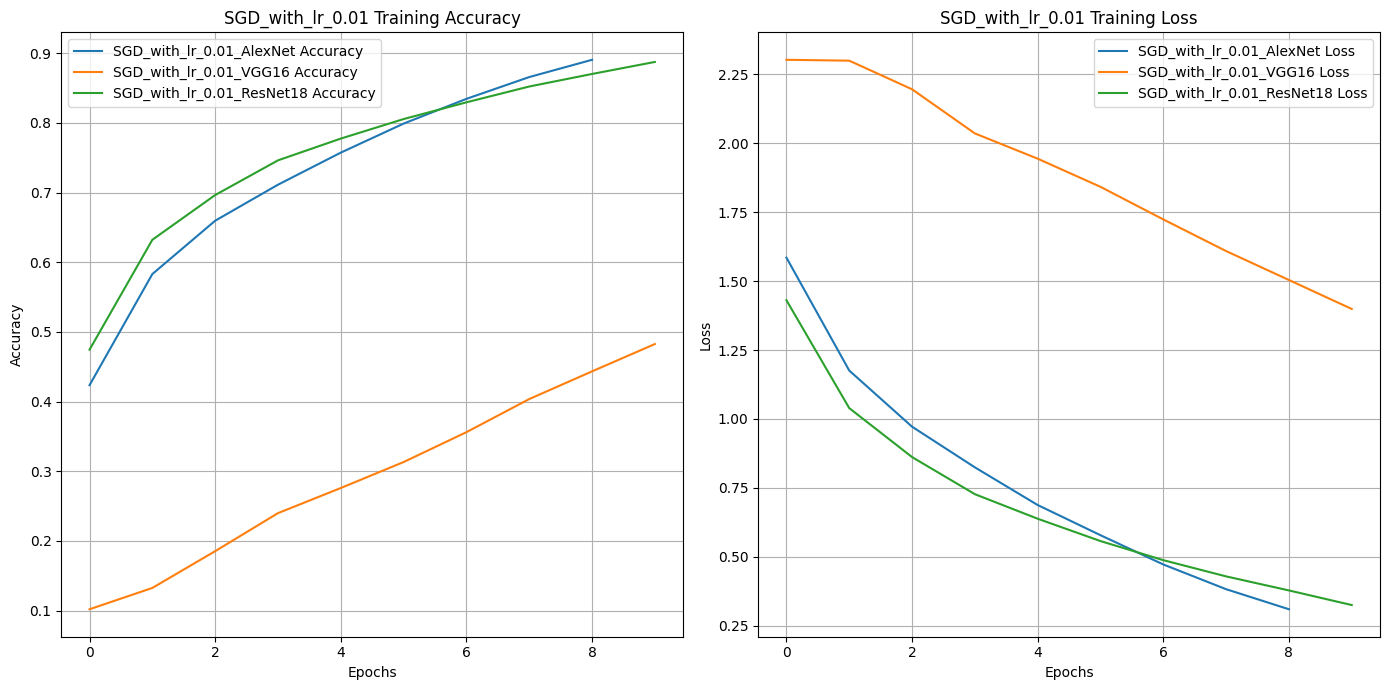

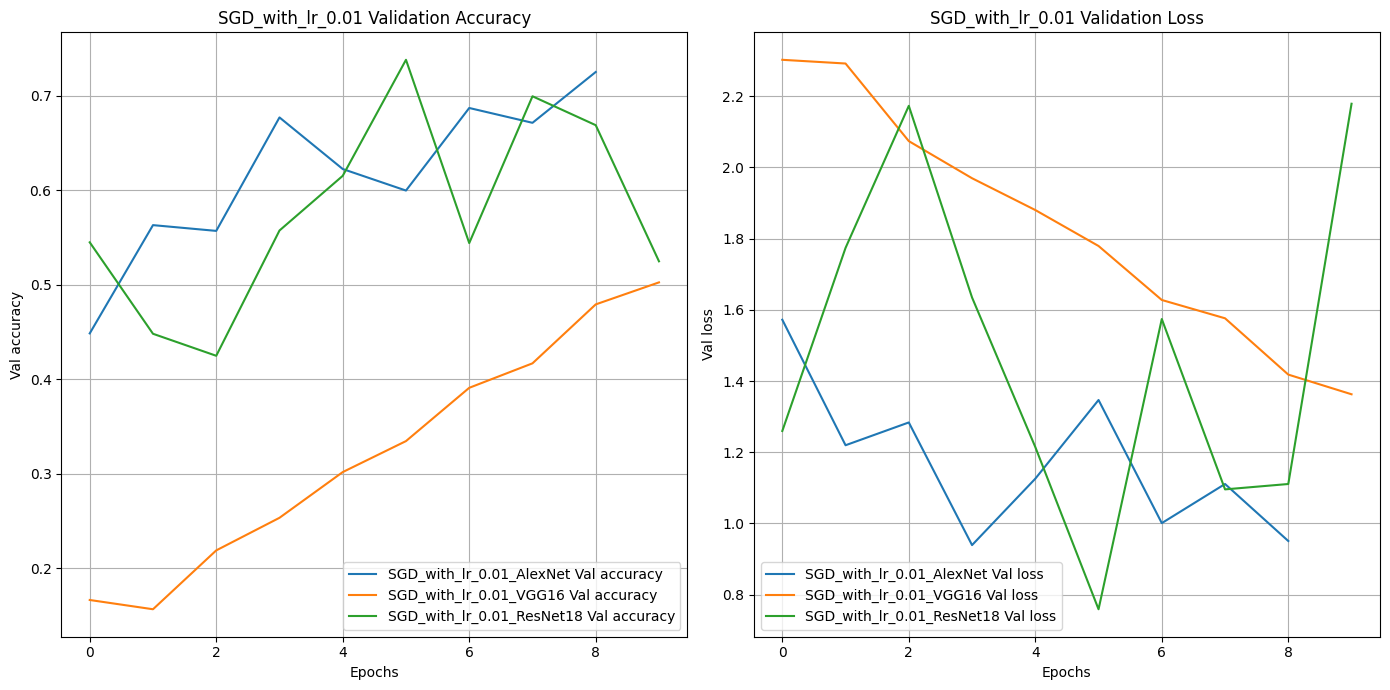

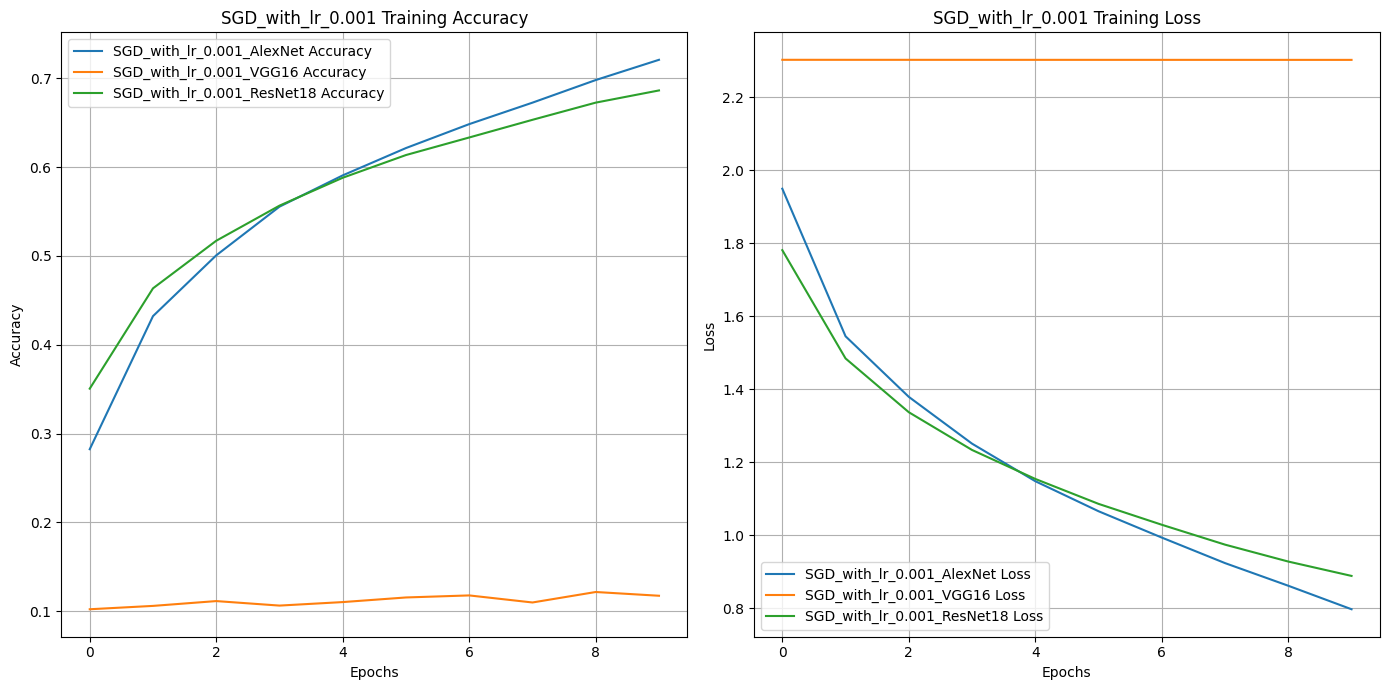

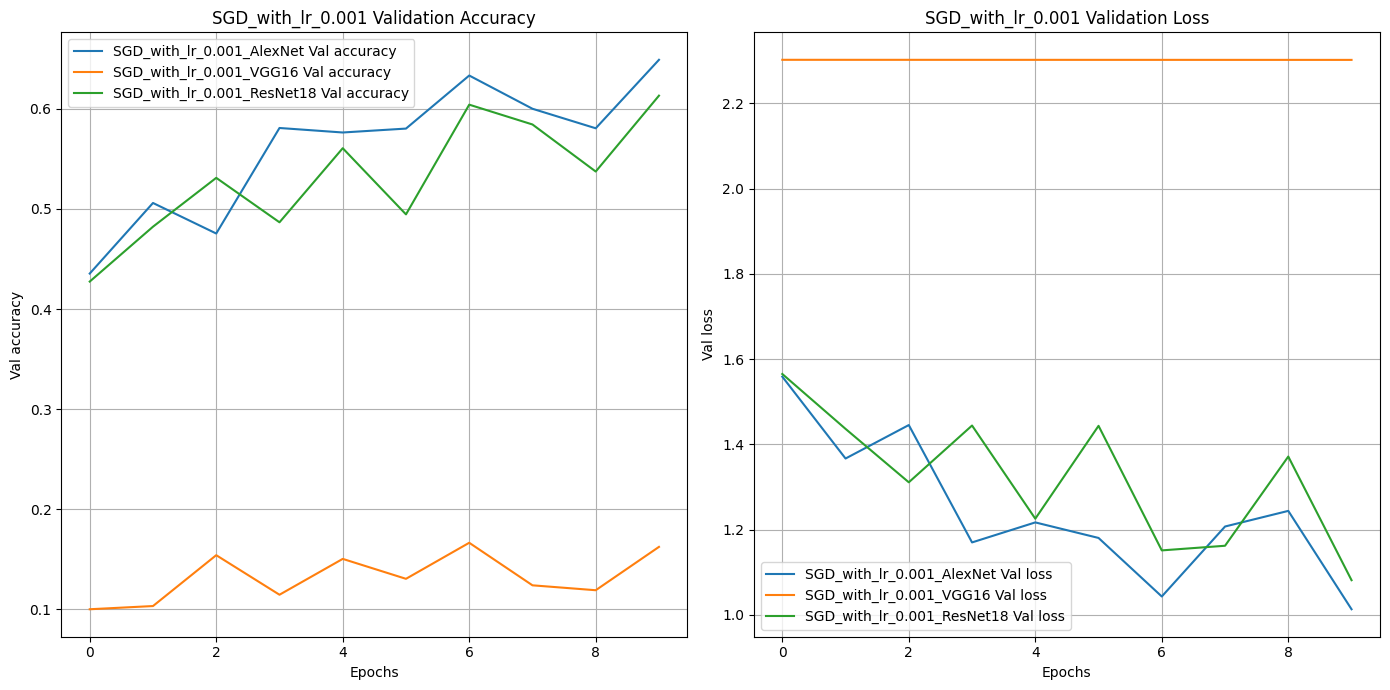

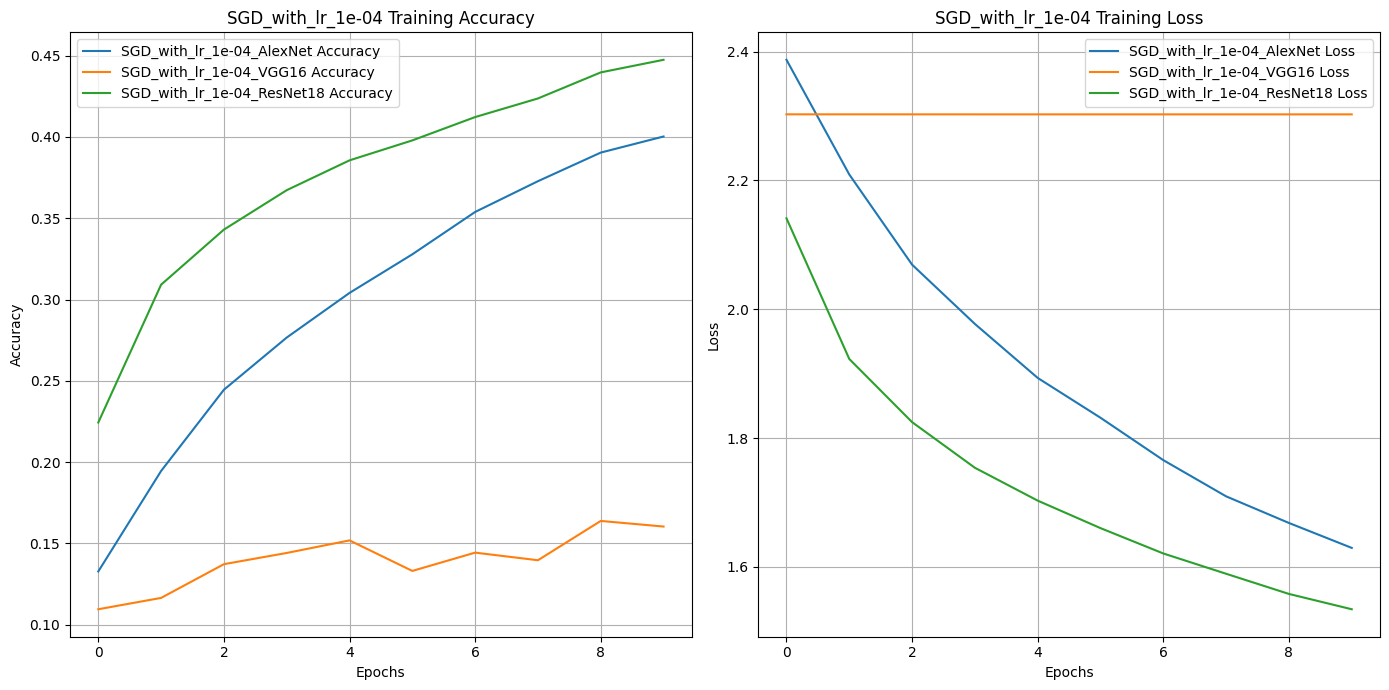

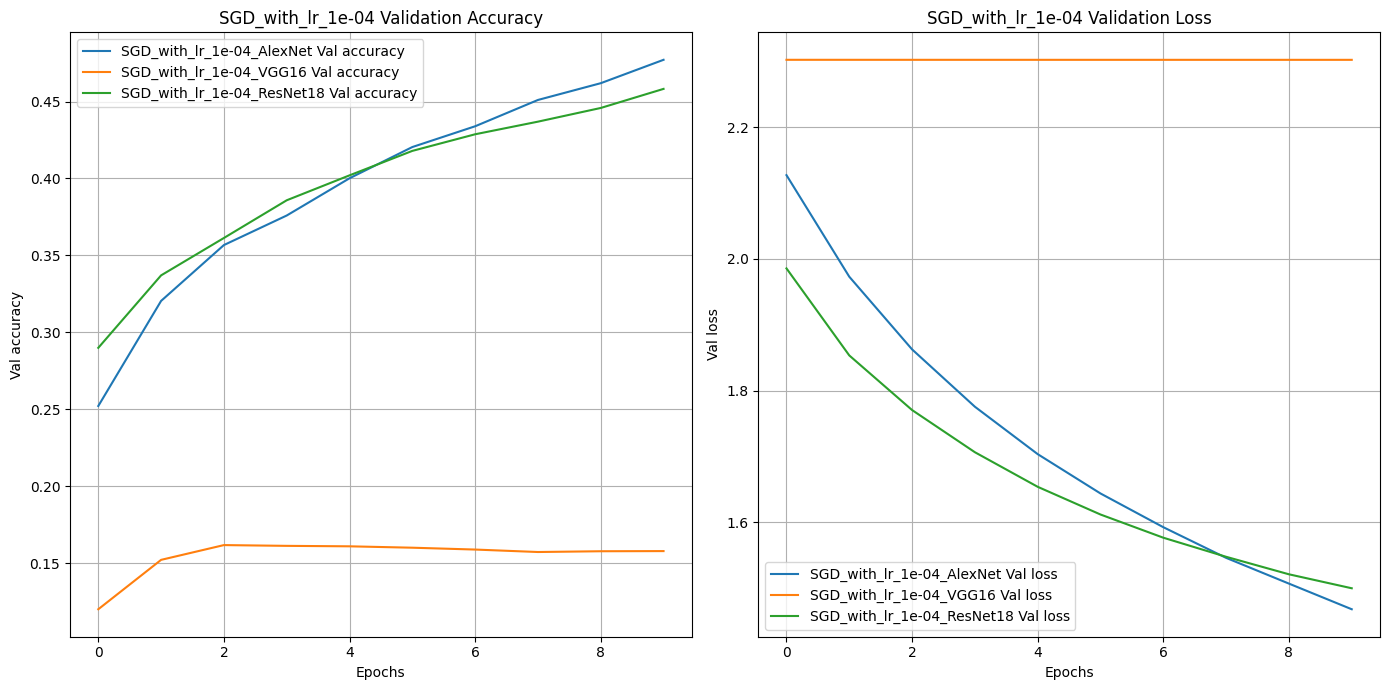

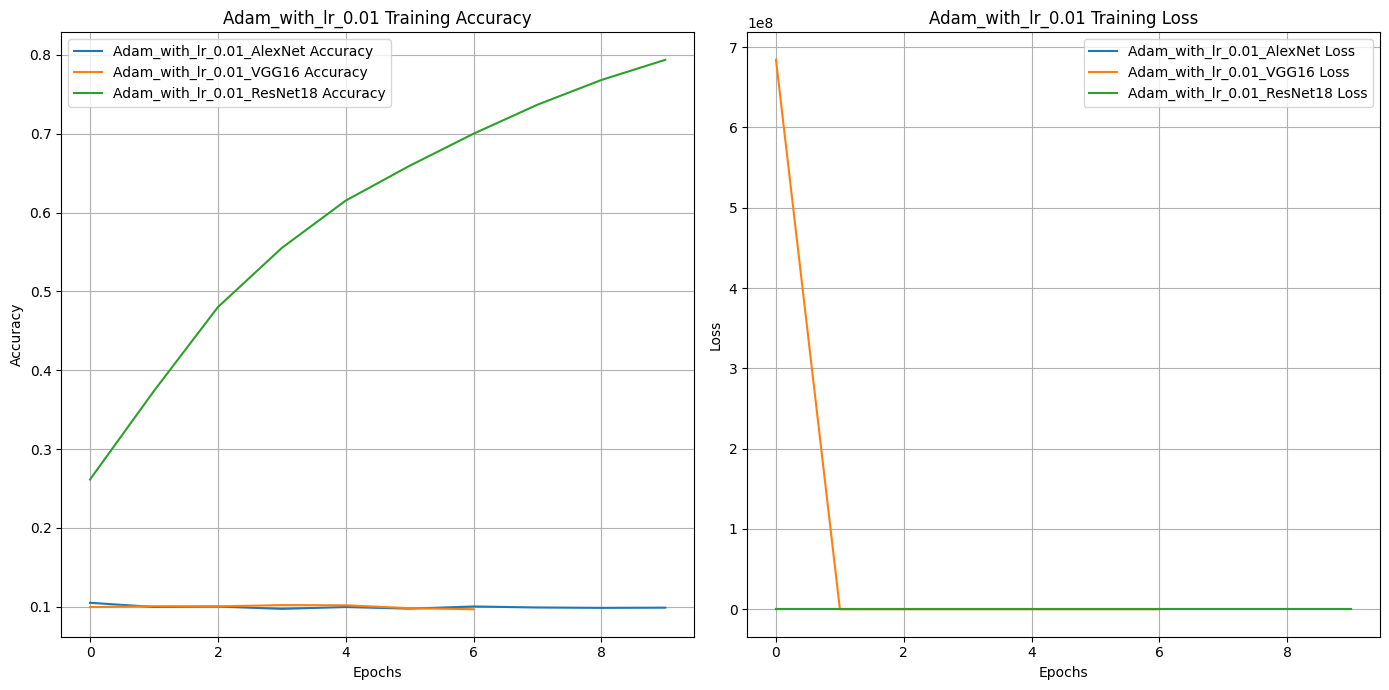

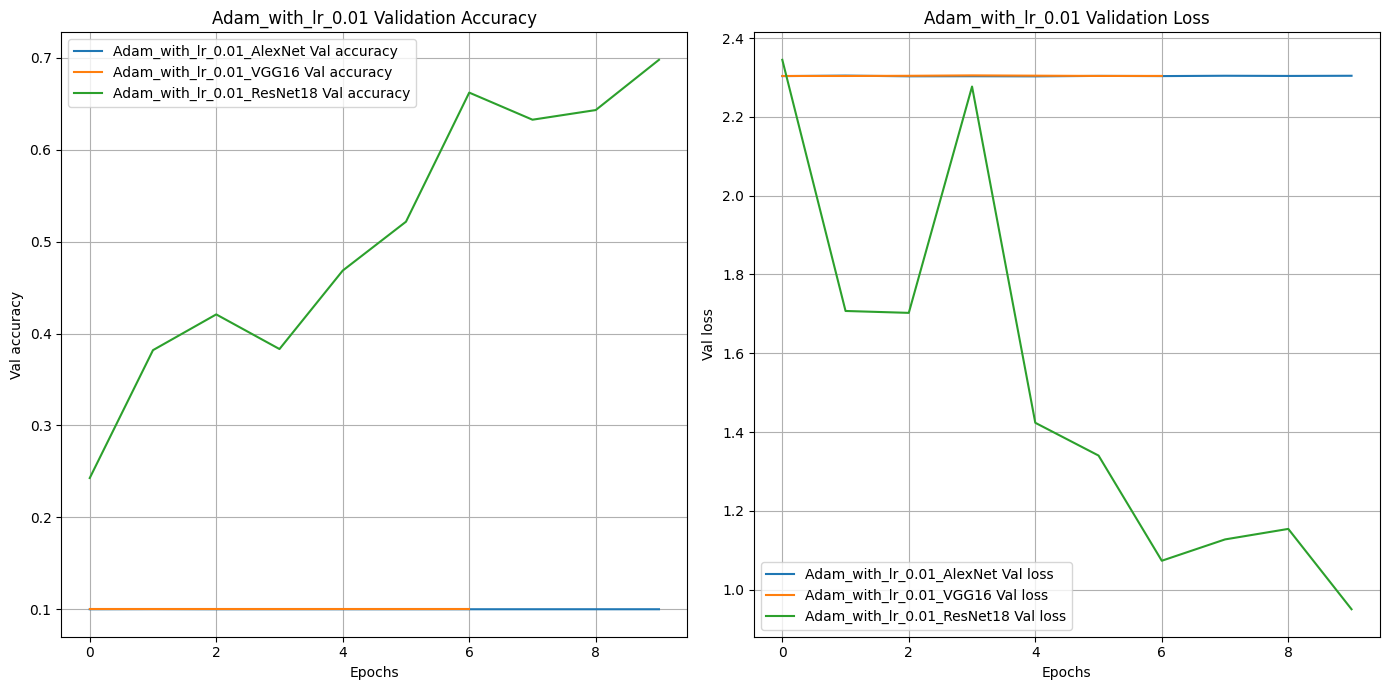

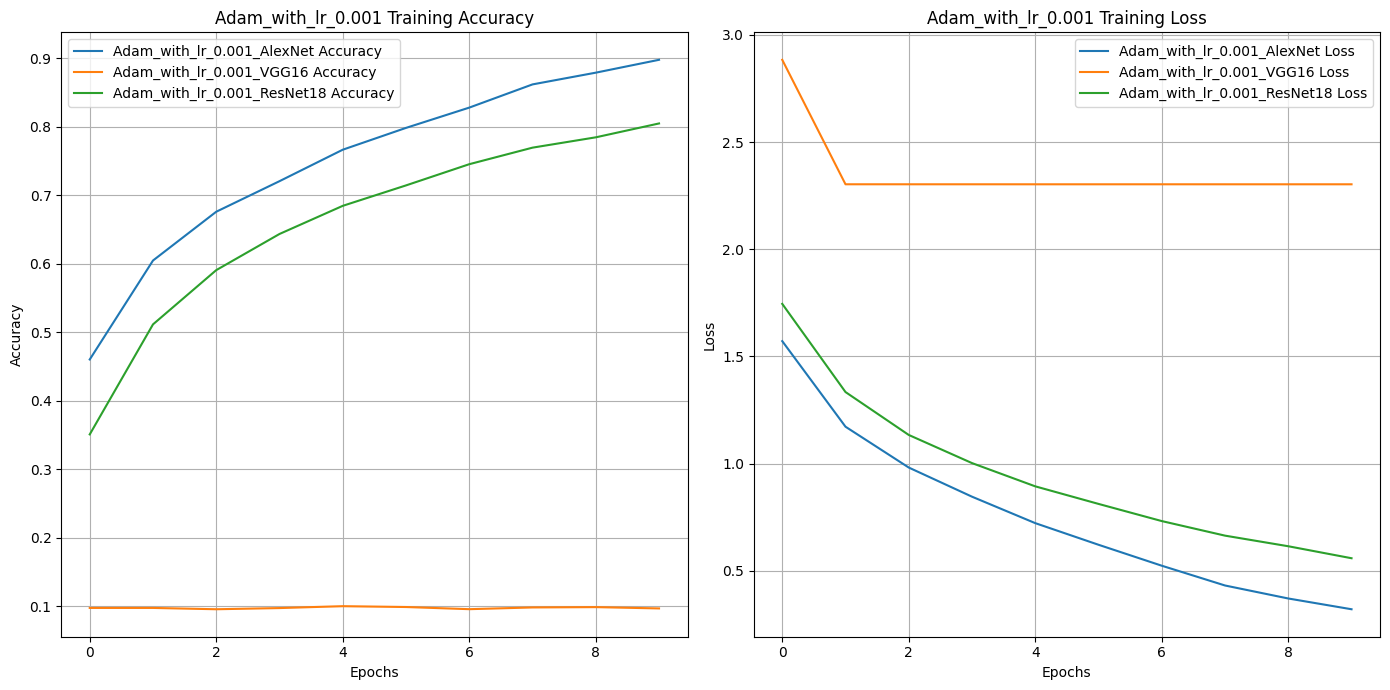

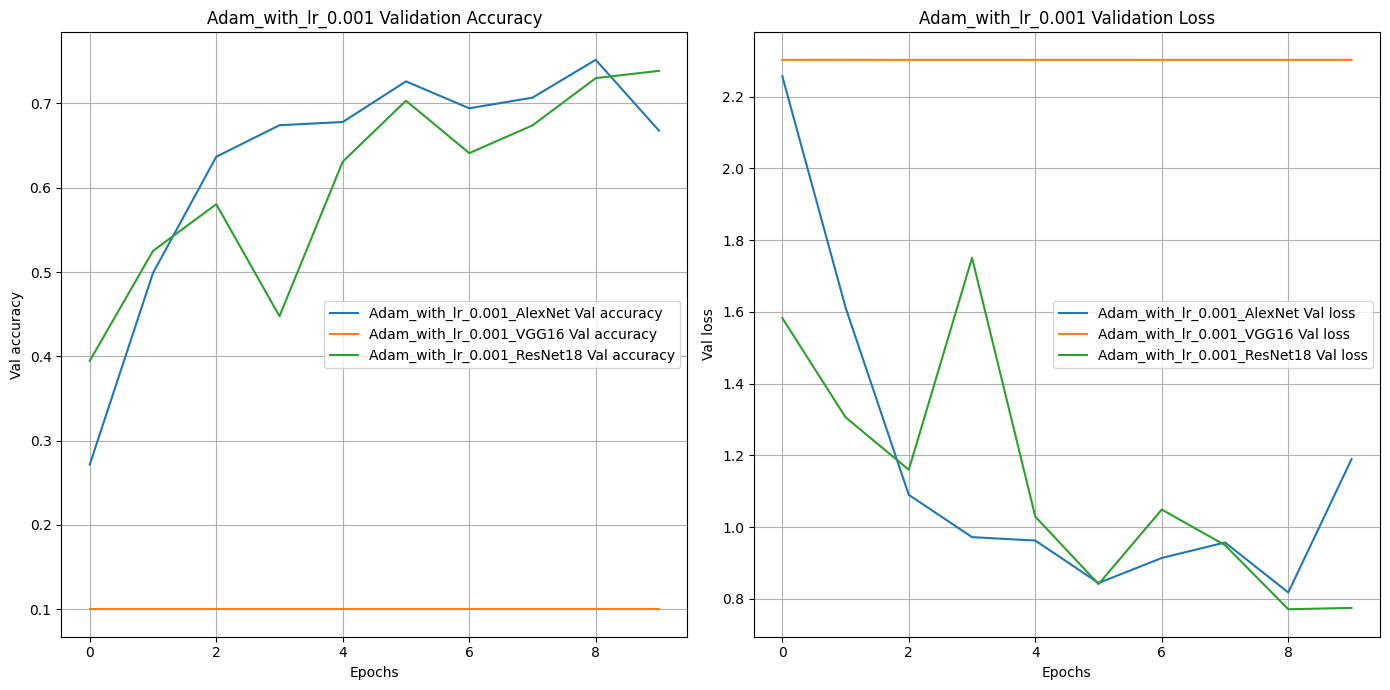

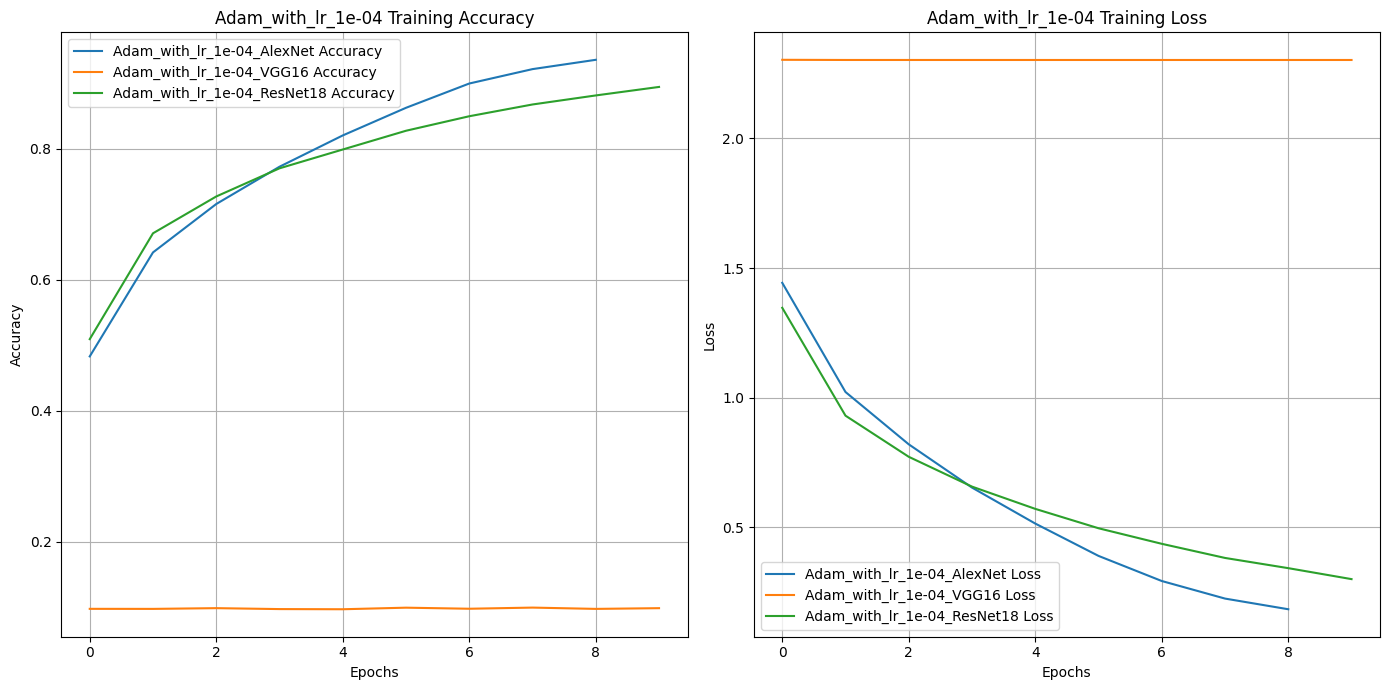

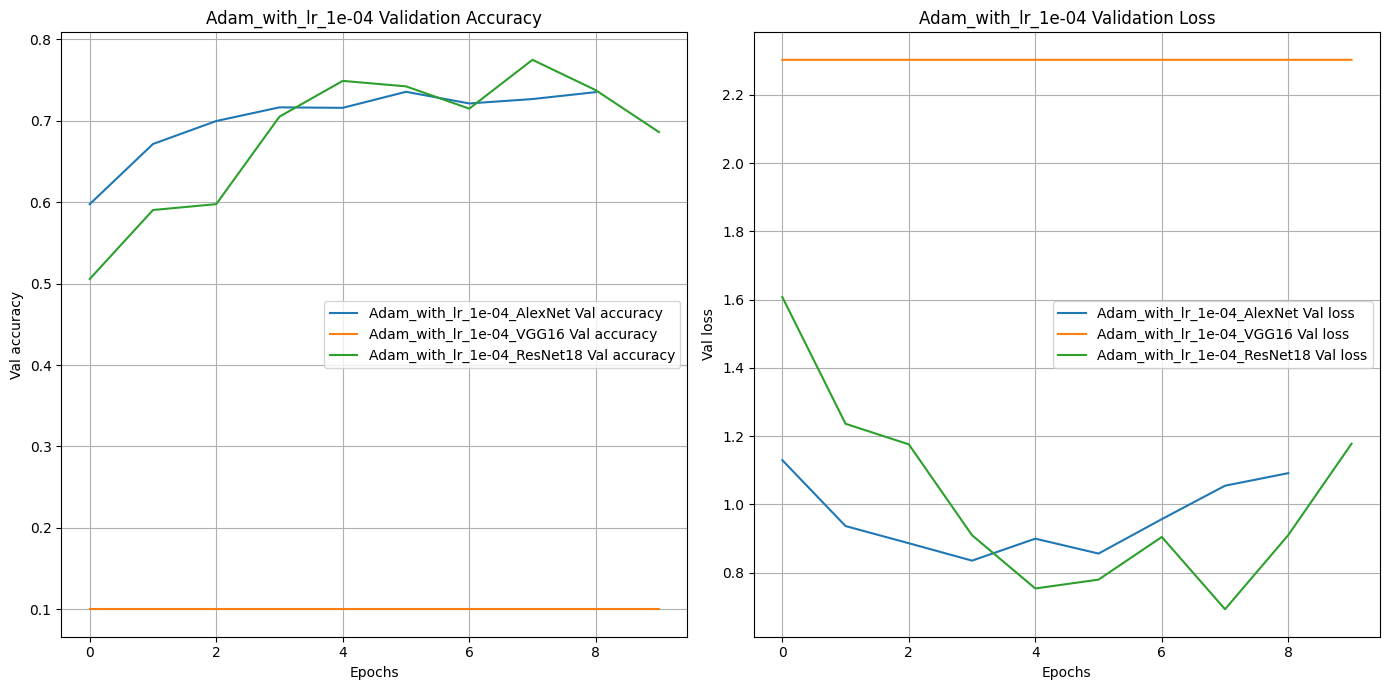

In [7]:
optimizers = [tf.keras.optimizers.SGD(learning_rate=0.01), tf.keras.optimizers.SGD(learning_rate=0.001), tf.keras.optimizers.SGD(learning_rate=0.0001),
              tf.keras.optimizers.Adam(learning_rate=0.01), tf.keras.optimizers.Adam(learning_rate=0.001), tf.keras.optimizers.Adam(learning_rate=0.0001)]

for i in optimizers:
    for key in parameters.keys():
        parameters[key]["optimizer"] = i
    optimizer_histories = train_all(model_dict, parameters, f'{i.__class__.__name__}_with_lr_{str(i.learning_rate.numpy())}_', 10, train_model)
    compare_training_metrics(optimizer_histories, f'{i.__class__.__name__}_with_lr_{str(i.learning_rate.numpy())}')

### 5.2 Regularization

#### Dropout

In [ ]:
def build_vgg16_with_dropout(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.5):
    model = models.Sequential()

    # Convolutional blocks
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten and fully connected layers with dropout
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


def build_resnet18_droupout(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # First block with Dropout
    x = residual_block(x, 64)
    x = layers.Dropout(dropout_rate)(x)
    x = residual_block(x, 64)
    x = layers.Dropout(dropout_rate)(x)

    # Second block with Dropout
    x = residual_block(x, 128, downsample=True)
    x = layers.Dropout(dropout_rate)(x)
    x = residual_block(x, 128)
    x = layers.Dropout(dropout_rate)(x)

    # Add Dropout between blocks
    # (continue similar for other blocks...)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model


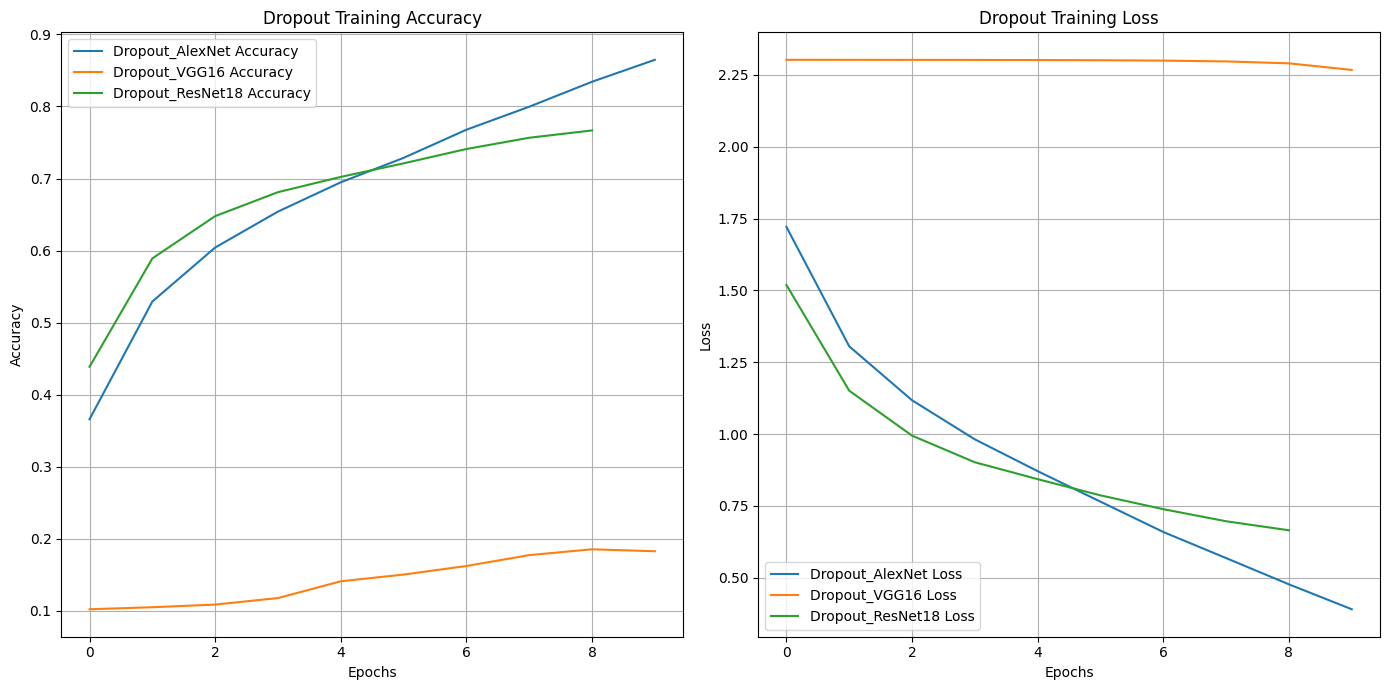

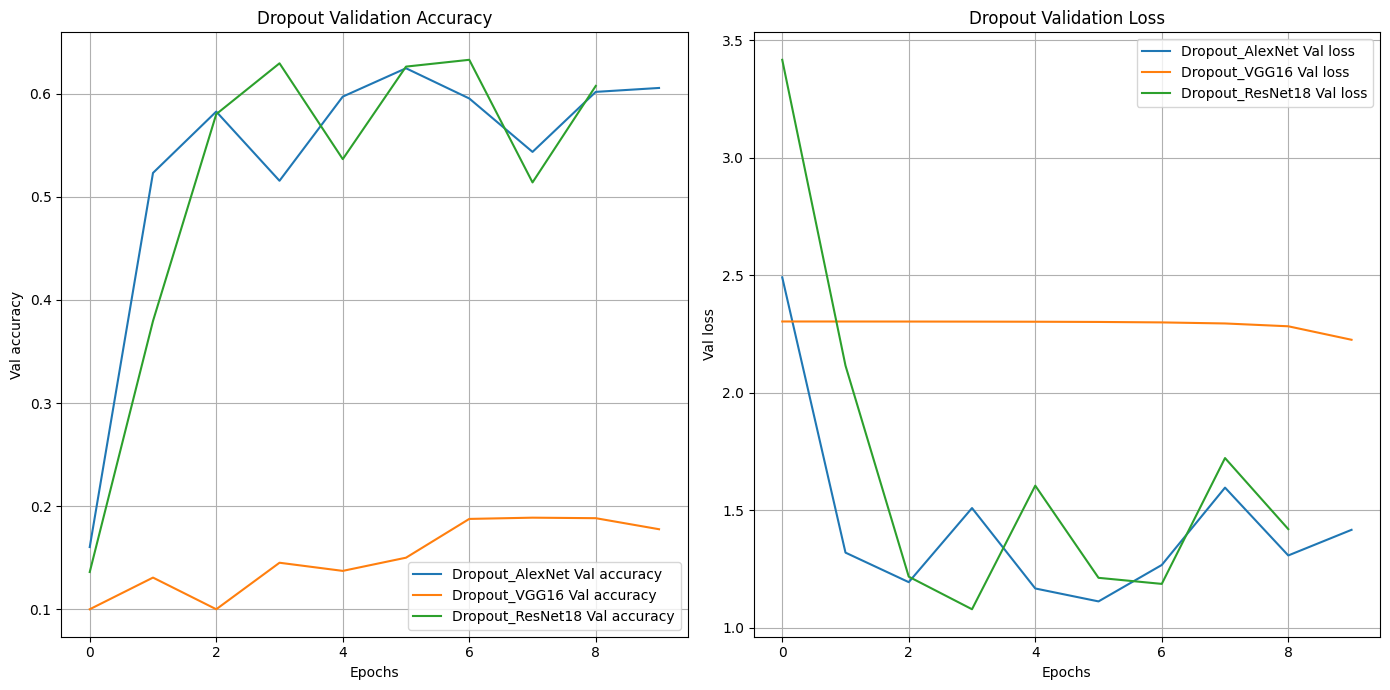

In [9]:
model_dict = {'AlexNet':build_alexnet,  'VGG16':build_vgg16_with_dropout, 'ResNet18':build_resnet18_droupout}

parameters = {"AlexNet" : {'optimizer': tf.keras.optimizers.SGD(learning_rate=0.01)},
              "VGG16" : {'optimizer': tf.keras.optimizers.SGD(learning_rate=0.01)},
              "ResNet18" : {'optimizer':tf.keras.optimizers.Adam(learning_rate=0.001)}}

dropout_histories = train_all(model_dict, parameters, 'Dropout_', 10, train_model)

compare_training_metrics(dropout_histories, "Dropout")

#### L2 Regularization

In [10]:
def build_alexnet_with_l2(input_shape=(32, 32, 3), num_classes=10, l2_penalty=0.01):
    model = models.Sequential()

    # 1st Convolutional Layer
    model.add(layers.Conv2D(filters=96, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 2nd Convolutional Layer
    model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 3rd Convolutional Layer
    model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())

    # 4th Convolutional Layer
    model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())

    # 5th Convolutional Layer
    model.add(layers.Conv2D(filters=256, kernel_size=(1, 1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten and fully connected layers with L2 regularization
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu', kernel_regularizer=l2(l2_penalty)))
    model.add(layers.Dense(4096, activation='relu', kernel_regularizer=l2(l2_penalty)))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


def build_vgg16_with_l2(input_shape=(32, 32, 3), num_classes=10, l2_penalty=0.01):
    model = models.Sequential()

    # Convolutional blocks
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten and fully connected layers with L2 regularization
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu', kernel_regularizer=l2(l2_penalty)))
    model.add(layers.Dense(4096, activation='relu', kernel_regularizer=l2(l2_penalty)))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model



def residual_block_l2(x, filters, kernel_size=3, stride=1, downsample=False, l2_penalty=0.01):
    identity = x
    if downsample:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                                 kernel_regularizer=l2(l2_penalty))(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', 
                      kernel_regularizer=l2(l2_penalty))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', 
                      kernel_regularizer=l2(l2_penalty))(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, identity])
    x = layers.ReLU()(x)
    return x

def build_resnet18_with_l2(input_shape=(32, 32, 3), num_classes=10, use_residual=True):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Select the type of block based on the `use_residual` flag
    block_fn = residual_block_l2 if use_residual else plain_block

    x = block_fn(x, 64)
    x = block_fn(x, 64)

    x = block_fn(x, 128, downsample=True)
    x = block_fn(x, 128)

    x = block_fn(x, 256, downsample=True)
    x = block_fn(x, 256)

    x = block_fn(x, 512, downsample=True)
    x = block_fn(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

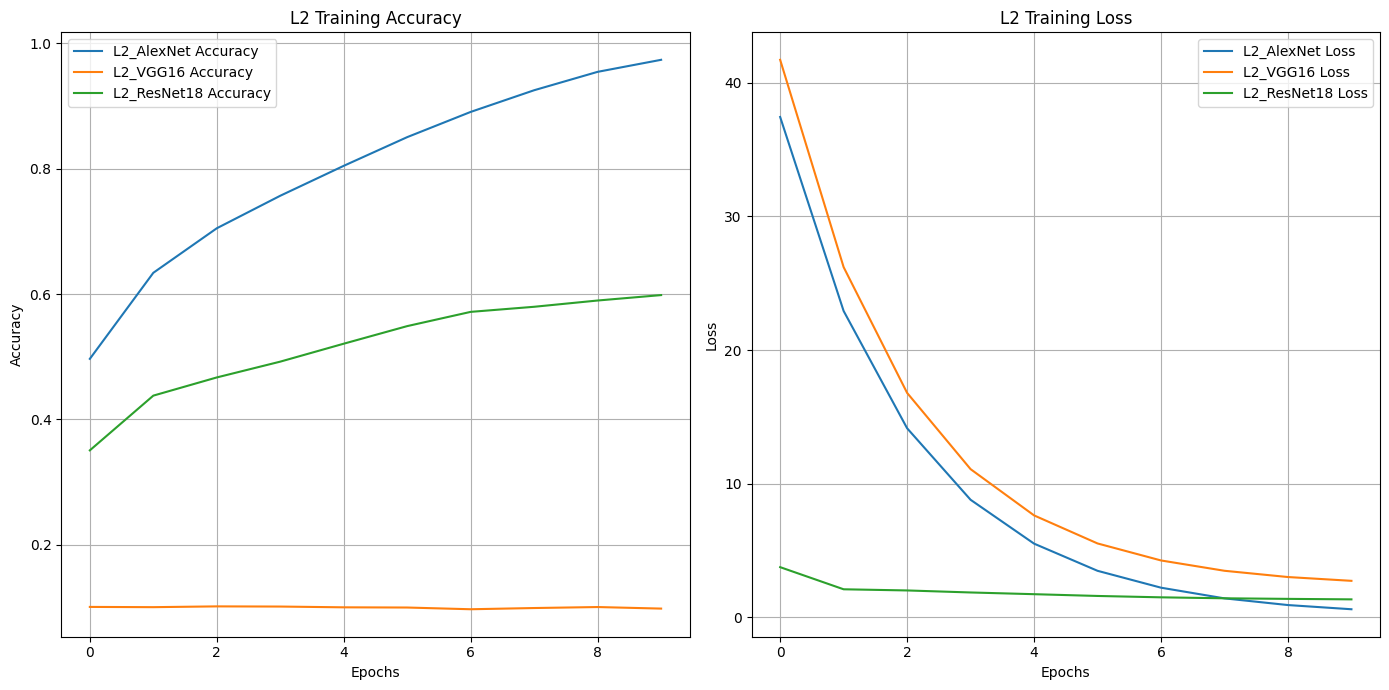

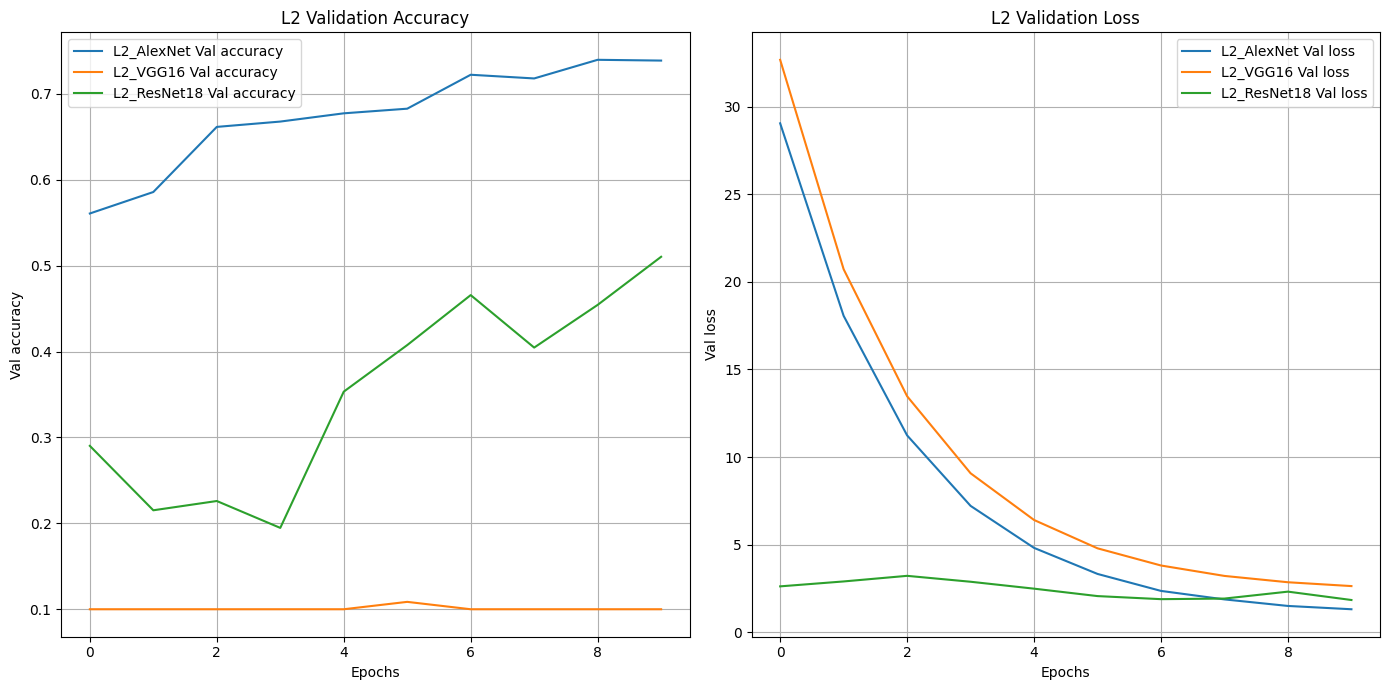

In [11]:
model_dict = {'AlexNet':build_alexnet_with_l2,  'VGG16':build_vgg16_with_l2, 'ResNet18':build_resnet18_with_l2}

parameters = {"AlexNet" : {'optimizer': tf.keras.optimizers.SGD(learning_rate=0.01)},
              "VGG16" : {'optimizer': tf.keras.optimizers.SGD(learning_rate=0.01)},
              "ResNet18" : {'optimizer':tf.keras.optimizers.Adam(learning_rate=0.001)}}

L2_histories = train_all(model_dict, parameters, 'L2_', 10, train_model)

compare_training_metrics(L2_histories, "L2")

### 5.3 Data Augmentation

In [12]:
# Create an instance of ImageDataGenerator for training data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,      # Rotate images by up to 15 degrees
    width_shift_range=0.1,  # Shift width by 10%
    height_shift_range=0.1, # Shift height by 10%
    horizontal_flip=True,   # Flip images horizontally
    zoom_range=0.1          # Zoom in/out by 10%
)

# Create an instance of ImageDataGenerator for training data augmentation
# train_datagen = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05, height_shift_range=0.05)

# Apply the ImageDataGenerator to the training set
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)



In [13]:
# Update train_model function to use train_generator
def train_model_augmented(build_model, model_name, parameters, epoch, model_dir='saved_models', verbose=1):
    # Check if model already exists in the directory
    model_path = os.path.join(model_dir, f'{model_name}.h5')
    history_path = os.path.join(model_dir, f'{model_name}_history.pkl')
    
    if os.path.exists(model_path):
        model = load_model(model_path)
        if os.path.exists(history_path):
            with open(history_path, 'rb') as f:
                history = pickle.load(f)
        else:
            history = None
        return history, model  # Return history and model
    
    # If not found, train a new model
    model = build_model()
    model.compile(optimizer=parameters["optimizer"],
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # Use train_generator instead of raw training data
    history = model.fit(
        train_generator, 
        epochs=epoch, 
        validation_data=(X_val, y_val), 
        steps_per_epoch=len(X_train) // batch_size,
        callbacks=[early_stopping],
        verbose=verbose
    )
    
    # Save the model and history
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model.save(model_path)
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    
    return history, model


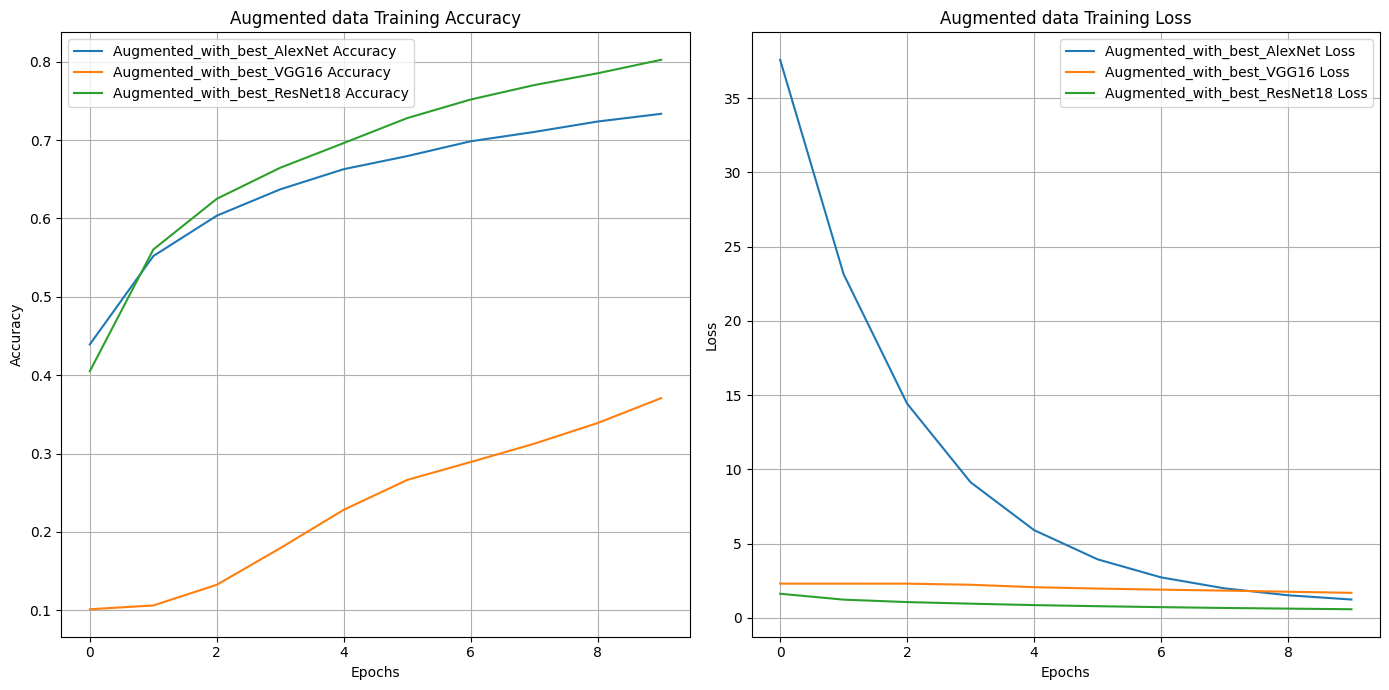

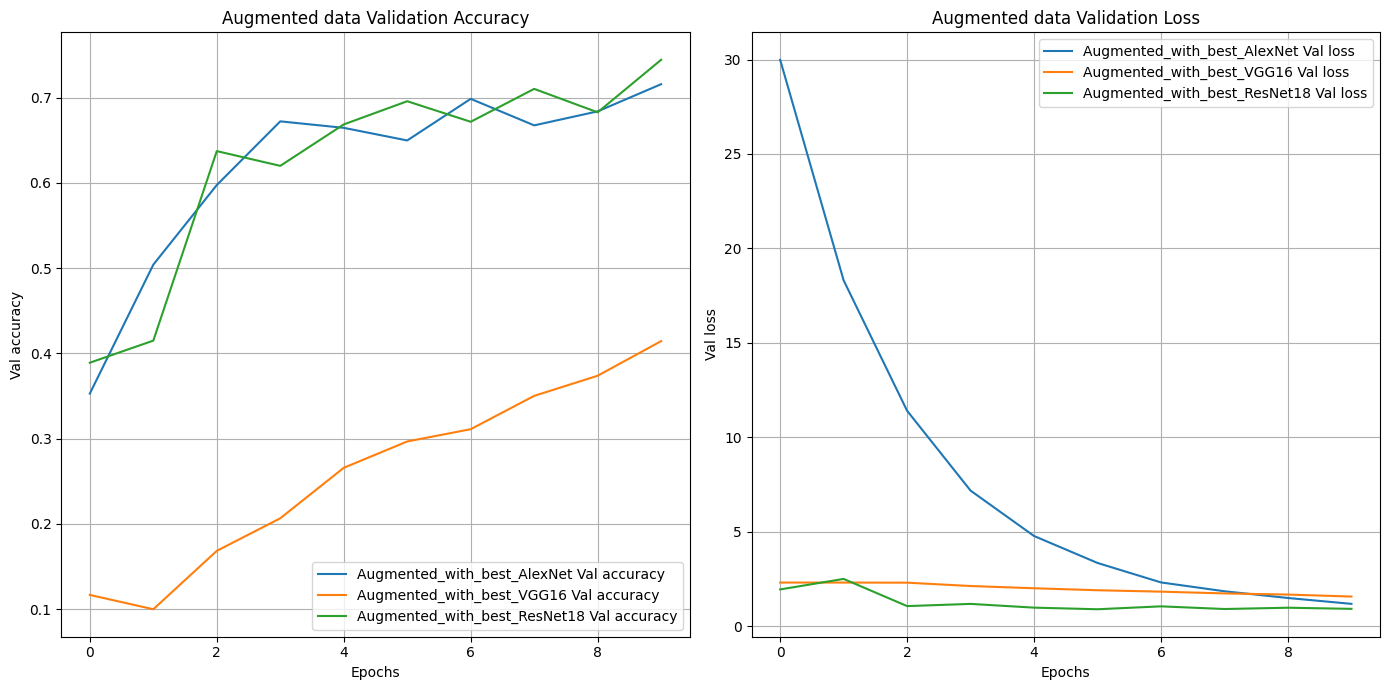

In [14]:
model_dict = {'AlexNet':build_alexnet_with_l2,  'VGG16':build_vgg16, 'ResNet18':build_resnet18}

parameters = {"AlexNet" : {'optimizer': tf.keras.optimizers.SGD(learning_rate=0.01)},
              "VGG16" : {'optimizer': tf.keras.optimizers.SGD(learning_rate=0.01)},
              "ResNet18" : {'optimizer':tf.keras.optimizers.Adam(learning_rate=0.001)}}

augmented_histories = train_all(model_dict, parameters, 'Augmented_with_best_', 10, train_model_augmented)

compare_training_metrics(augmented_histories, "Augmented data")

### 5.4 Without Residual Connections

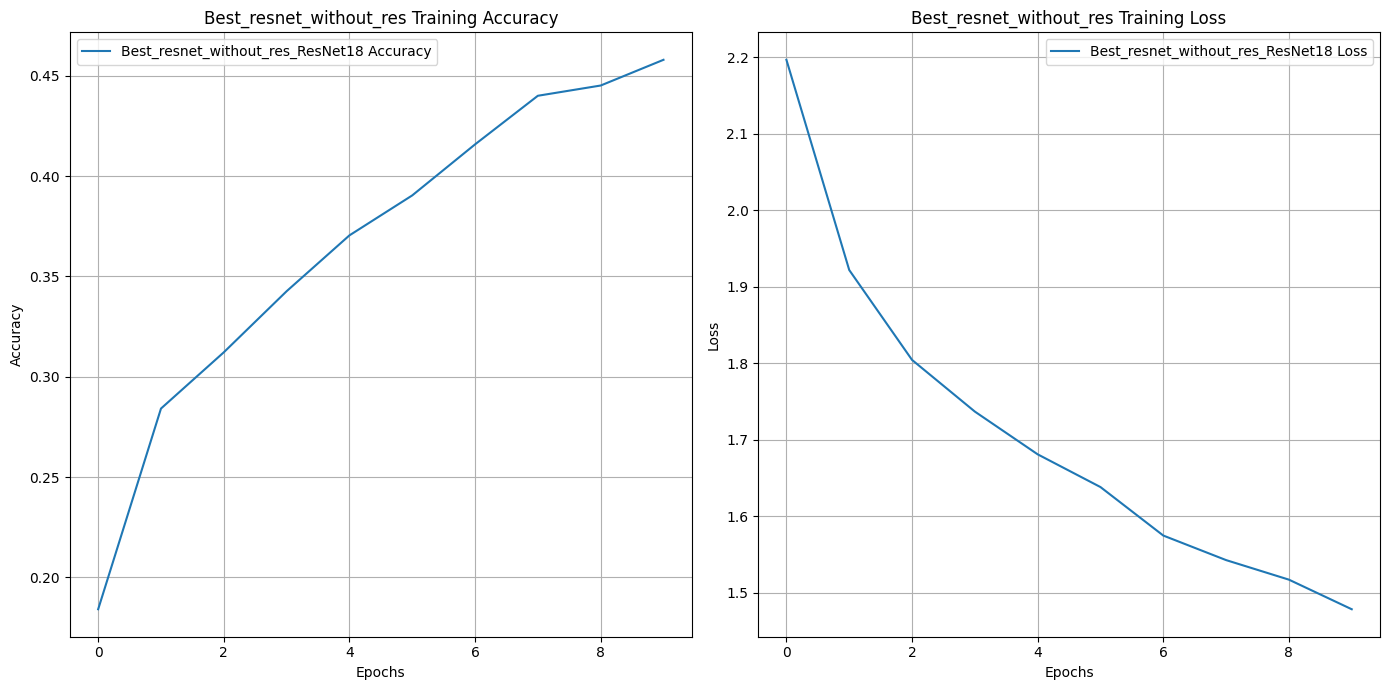

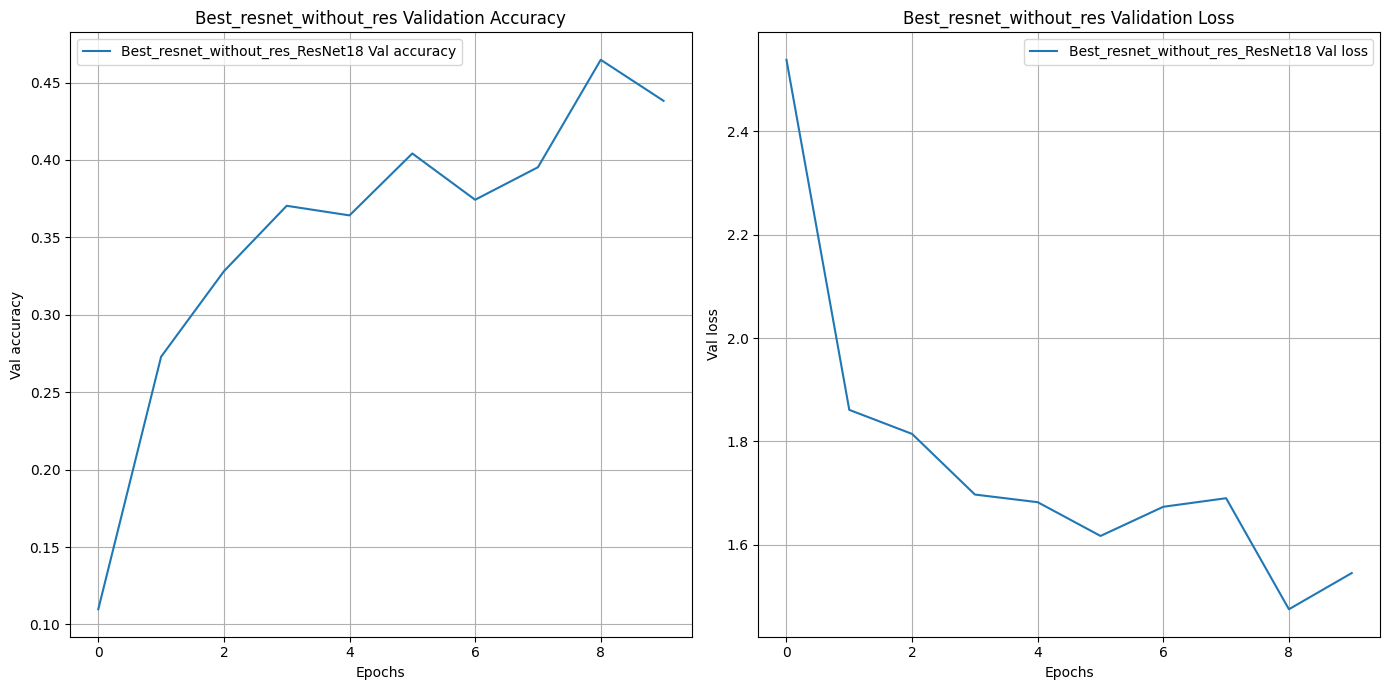

In [15]:
model_dict = {"ResNet18":lambda: build_resnet18(use_residual=False)}

best_resnet_without_res_histories = train_all(model_dict, parameters, 'Best_resnet_without_res_', 10, train_model_augmented)
compare_training_metrics(best_resnet_without_res_histories, "Best_resnet_without_res")


## 6. Final Test

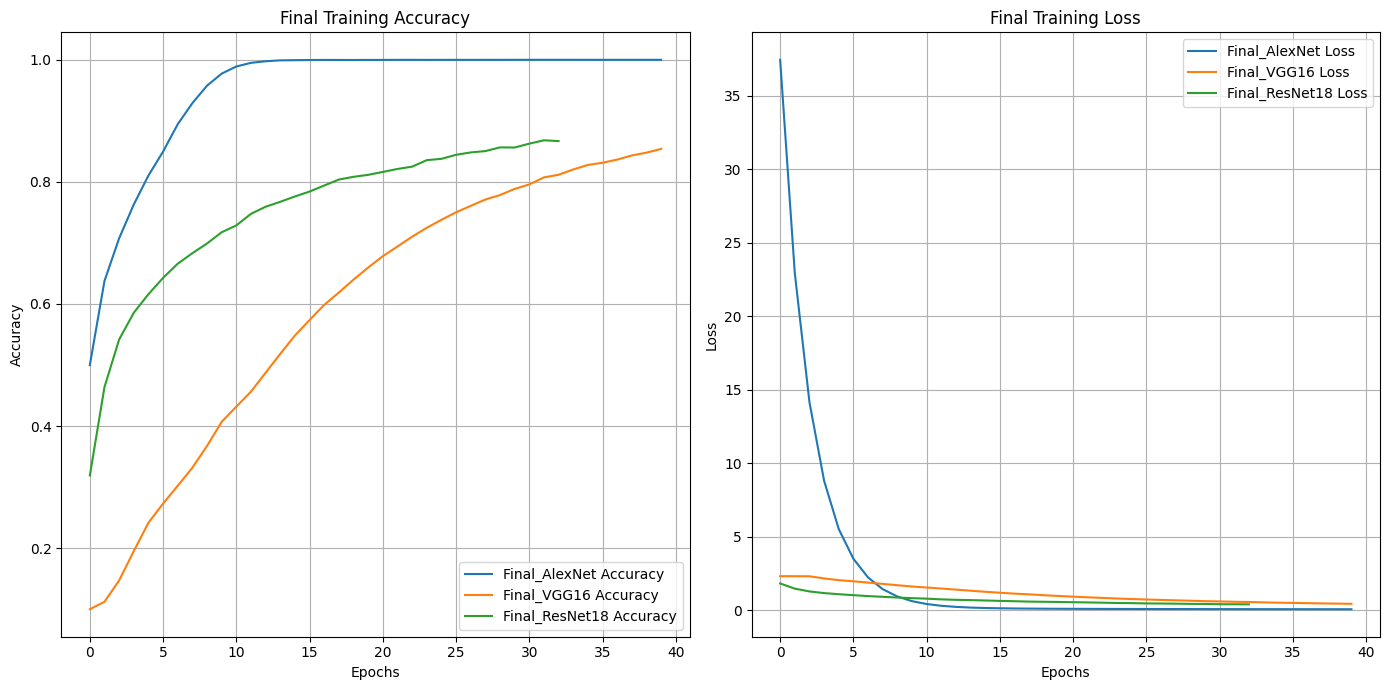

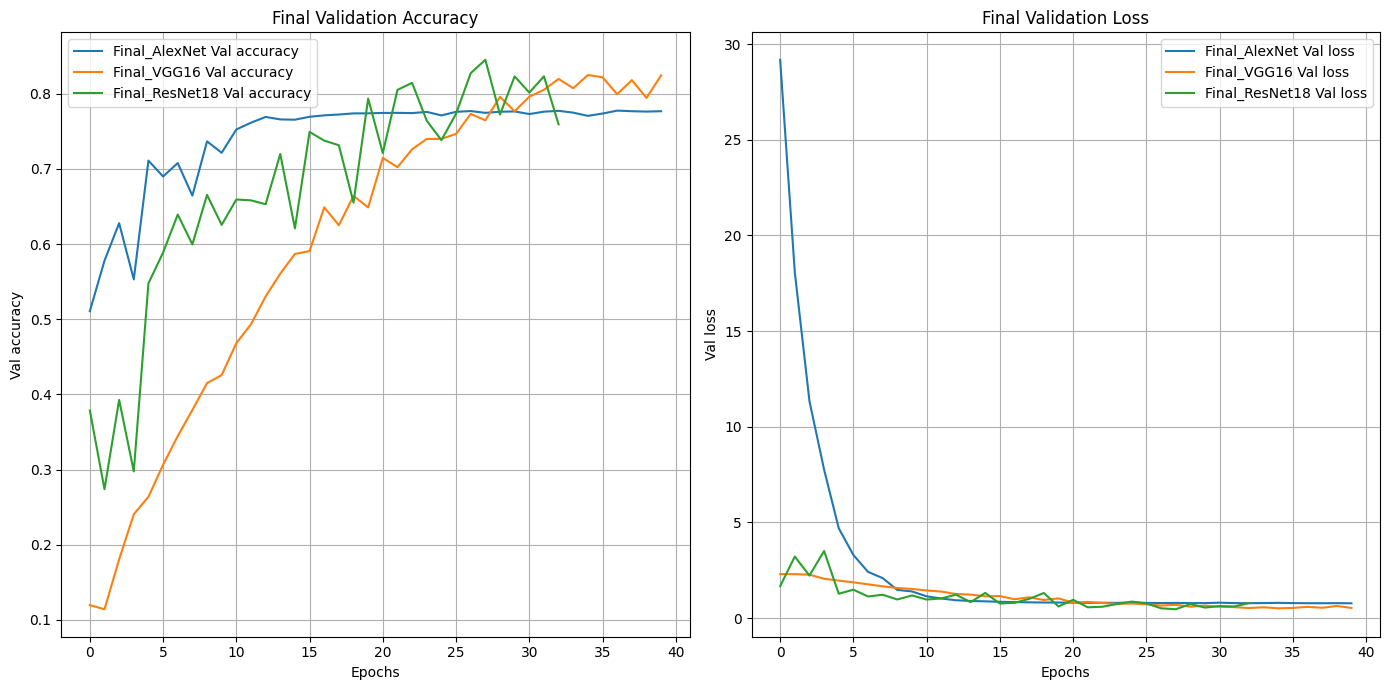

In [16]:
model_dict = {'AlexNet':build_alexnet_with_l2,  'VGG16':build_vgg16, 'ResNet18':build_resnet18}

parameters = {"AlexNet" : {'optimizer': tf.keras.optimizers.SGD(learning_rate=0.01)},
              "VGG16" : {'optimizer': tf.keras.optimizers.SGD(learning_rate=0.01)},
              "ResNet18" : {'optimizer':tf.keras.optimizers.Adam(learning_rate=0.001)}}

Final_histories = train_all(model_dict, parameters, 'Final_', 40, train_model_augmented)

compare_training_metrics(Final_histories, "Final")

## 7. Results

Test Accuracy for Final_AlexNet: 77.46%
Test Accuracy for Final_VGG16: 81.91%
Test Accuracy for Final_ResNet18: 84.03%


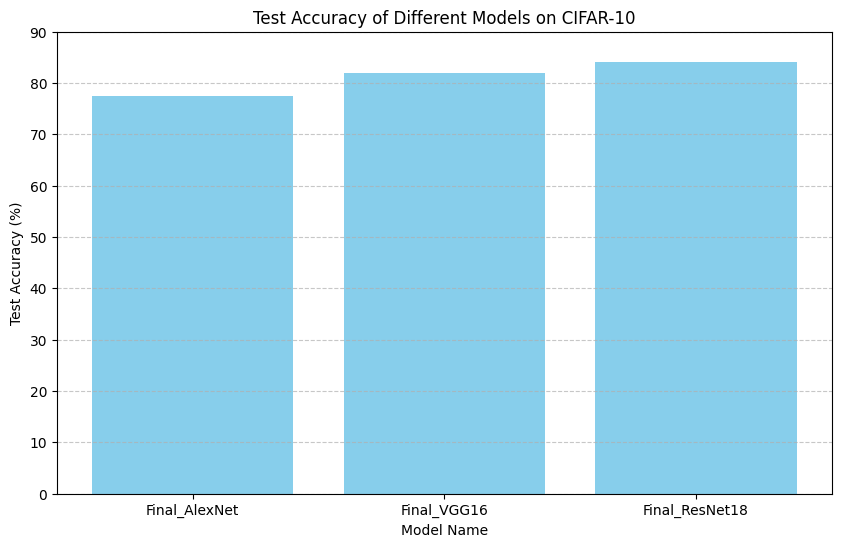

In [17]:
model_names = ['Final_AlexNet', 'Final_VGG16', 'Final_ResNet18']

# Dictionary to store each model and its test accuracy
model_accuracies = {}

# Loop to load each model and evaluate on the test set
for model_name in model_names:
    model_path = os.path.join('saved_models', f'{model_name}.h5')
    
    # Load the model
    model = load_model(model_path)
    
    # Predict on the test set
    predictions = model.predict(X_test, verbose=0)
    
    # Convert predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(predicted_classes == true_classes)
    model_accuracies[model_name] = accuracy * 100 

for model_name, accuracy in model_accuracies.items():
    print(f'Test Accuracy for {model_name}: {accuracy:.2f}%')

model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model Name')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy of Different Models on CIFAR-10')
plt.ylim(0, 90)  # Set y-axis limit from 0 to 100 for better context
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()